<left>FINM 36702 - Portfolio Credit Risk: Modeling and Estimation</left>
<left>Spring 2023</left>
<br>
<h1><center> Assignment 2 </center></h1>
<center>Due - 18:00 [CST] April 6th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import pandas as pd
from functools import partial
import matplotlib.pyplot as plt
import sympy
from scipy.optimize import minimize

### Helper Functions

In [3]:
def sim_MVN(mu, sigma, strands, seed):
    np.random.seed(seed) # setting the seed
    return np.random.multivariate_normal(mu, sigma, strands) # returning the simulated numpy array

In [4]:
def sim_Default(PDs, sim_result):
    threshold = np.tile(norm.ppf(PDs), (sim_result.shape[0], 1)) # matching the Gaussian default threshold format
    relative_position = sim_result - threshold # getting the relevant position of the simulation in terms of threshold

    return np.where(relative_position < 0, 1, 0) # returning numpy array with "1" as default and "0" otherwise

In [5]:
def Default_summary(sim_result):
    agg = sim_result.sum(axis = 1)
    df = pd.DataFrame({'Number of Firms': [agg.mean(), agg.std()]},
                      index = ['Mean', 'Std. Dev.'])

    return df

In [6]:
def Sigma_generator(rho, nrow):
    sigma = []
    for i in range(nrow):
        row = []
        for j in range(nrow):
            if i == j:
                row.append(1)
            else:
                row.append(rho)
        sigma.append(row)

    return np.array(sigma)

In [7]:
def MC_Default_std(rho, PDs, mu, strands, seed):
    Sigma = Sigma_generator(rho, len(PDs))
    sim_result = sim_Default(PDs, sim_MVN(mu, Sigma, strands, seed))
    return sim_result.sum(axis = 1).std()

In [8]:
def MVN_p(rho, pd_1, pd_2):
    try:
        rho = rho[0]
    except:
        pass
    mu = np.array([0, 0], dtype = float)
    sigma = np.array([[1, rho], [rho, 1]], dtype = float)
    inv_cdf_1 = norm.ppf(pd_1)
    inv_cdf_2 = norm.ppf(pd_2)

    # add a small positive value to the diagonal entries of the covariance matrix
    sigma += np.eye(2) * 1e-8

    cdf = multivariate_normal(mean = mu, cov = sigma).cdf([inv_cdf_1, inv_cdf_2])

    return cdf

In [9]:
def f(x, pd_1, pd_2, pdj):
    return abs(MVN_p(x, pd_1, pd_2) - pdj)

### Constants

In [10]:
seed = 5881

# Question 1.

#### Given Correlation Matrix

In [11]:
mu_1 = np.repeat(0, 5)

In [12]:
Sigma_1 = np.array([[1, 0.05, 0.1, 0.15, 0.2],
                    [0.05, 1, 0.25, 0.3, 0.35],
                    [0.1, 0.25, 1, 0.4, 0.45],
                    [0.15, 0.3, 0.4, 1, 0.5],
                    [0.2, 0.35, 0.45, 0.5, 1]])

In [13]:
PDs_1 = np.array([0.5, 0.4, 0.3, 0.2, 0.1])

In [14]:
n_strands_1 = 10000

In [15]:
sim_results_1 = sim_MVN(mu_1, Sigma_1, n_strands_1, seed)

In [16]:
x = sim_Default(PDs_1, sim_results_1)

In [17]:
Default_summary(x)

,Number of Firms
Mean,1.501600
Std. Dev.,1.201914


#### Modified Correlation Matrix

In [18]:
Sigma_2 = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

In [19]:
sim_results_2 = sim_MVN(mu_1, Sigma_2, n_strands_1, seed)

In [20]:
x = sim_Default(PDs_1, sim_results_2)

In [21]:
Default_summary(x)

,Number of Firms
Mean,1.494200
Std. Dev.,0.976712


# Question 2.

In [22]:
rhos = np.arange(start = 0, stop = 0.95, step = 0.01)

In [23]:
n_strands_2 = 1000

In [24]:
partial_func = partial(MC_Default_std, PDs = PDs_1, mu = mu_1, strands = n_strands_2, seed = seed)

In [25]:
y = np.vectorize(partial_func)(rhos)

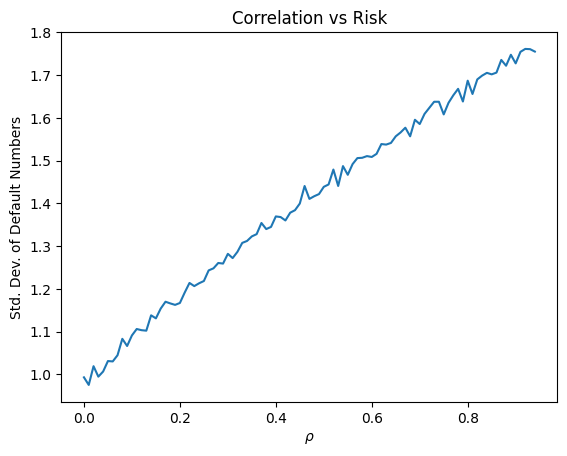

In [26]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data
ax.plot(rhos, y)

# Add labels and title
ax.set_xlabel(r'$\rho$')
ax.set_ylabel('Std. Dev. of Default Numbers')
ax.set_title('Correlation vs Risk')

# Show the plot
plt.show()
None

# Question 3.

#### PDJ of Firm 4 and Firm 5

In [27]:
PDs_3 = [0.1, 0.2, 0.3, 0.4, 0.5]

In [28]:
Sigma_3 = np.array([[1, 0.15, 0.2, 0.25, 0.3],
                    [0.15, 1, 0.25, 0.3, 0.35],
                    [0.2, 0.25, 1, 0.35, 0.4],
                    [0.25, 0.3, 0.35, 1, 0.45],
                    [0.3, 0.35, 0.4, 0.45, 1]])

In [29]:
multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                     np.inf, # Firm 2
                                                     np.inf, # Firm 3
                                                     norm.ppf(PDs_3)[3], # Firm 4
                                                     norm.ppf(PDs_3)[4]]) # Firm 5

0.27175852116748356

#### Conditional Default probability

In [30]:
joint_P = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                               np.inf, # Firm 2
                                                               norm.ppf(PDs_3)[2], # Firm 3
                                                               norm.ppf(PDs_3)[3], # Firm 4
                                                               norm.ppf(PDs_3)[4]]) # Firm 5

In [31]:
conditional_case = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                                        np.inf, # Firm 2
                                                                        norm.ppf(PDs_3)[2], # Firm 3
                                                                        np.inf, # Firm 4
                                                                        np.inf]) # Firm 5

In [32]:
joint_P/conditional_case

0.44324468696421687

#### Expected Loss Rate

In [33]:
n_strands_3 = 1000000

In [34]:
Exposures = np.array([700, 600, 500, 400, 300, 200, 100])

In [35]:
ELGDs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

In [36]:
Firms = np.array([1, 2, 3, 4, 5, 4, 5])

In [37]:
Expected_Loss = []
for firm in range(1, 6):
    Expected_Loss.append((Exposures * ELGDs)[Firms == firm].sum())

In [38]:
Expected_Loss = np.array(Expected_Loss)

In [39]:
sim_results_3 = sim_MVN(mu_1, Sigma_3, n_strands_3, seed)

In [40]:
x = sim_Default(PDs_3, sim_results_3)

In [41]:
(x.mean(axis = 0) * Expected_Loss).sum() / 2800

0.10650584285714286

#### Default Correlation

In [42]:
PDJ = multivariate_normal(mean = mu_1, cov = Sigma_3).cdf([np.inf, # Firm 1
                                                           np.inf, # Firm 2
                                                           norm.ppf(PDs_3)[2], # Firm 3
                                                           norm.ppf(PDs_3)[3], # Firm 4
                                                           np.inf]) # Firm 5

In [43]:
(PDJ - PDs_3[2] * PDs_3[3]) / ((PDs_3[2] * (1 - PDs_3[2]) * PDs_3[3] * (1 - PDs_3[3])) ** 0.5)

0.2177297759360109

# Question 4.

In [44]:
x, y = sympy.symbols('x y')
f_xy = (1 + 3*x - y) / 2

#### Getting Marginal Distributions

##### For X:

In [45]:
f_x = sympy.integrate(f_xy, (y, 0, 1))
print(f_x)

3*x/2 + 1/4


##### For Y:

In [46]:
f_y = sympy.integrate(f_xy, (x, 0, 1))
print(f_y)

5/4 - y/2


#### Getting PDJ

##### Quantile Function for X:

In [47]:
z, P = sympy.symbols('z P')
inv_F_x = sympy.solve(sympy.integrate(f_x, (x, 0, z)) - P, z)
inv_F_x

[-sqrt(48*P + 1)/6 - 1/6, sqrt(48*P + 1)/6 - 1/6]

In [48]:
inv_F_x = inv_F_x[1] # quantile needs to be between 0 and 1
print("Quantile function for X:", inv_F_x)

Quantile function for X: sqrt(48*P + 1)/6 - 1/6


In [49]:
PD_x = 0.1
x_lim = inv_F_x.subs([(P, PD_x)])
print("The default quantile for X under the distribution:", x_lim)

The default quantile for X under the distribution: 0.234719819293077


##### Quantile Function for Y:

In [50]:
inv_F_y = sympy.solve(sympy.integrate(f_y, (y, 0, z)) - P, z)
inv_F_y

[5/2 - sqrt(25 - 16*P)/2, sqrt(25 - 16*P)/2 + 5/2]

In [51]:
inv_F_y = inv_F_y[0] # quantile needs to be between 0 and 1
print("Quantile function for Y:", inv_F_y)

Quantile function for Y: 5/2 - sqrt(25 - 16*P)/2


In [52]:
PD_y = 0.2
y_lim = inv_F_y.subs([(P, PD_y)])
print("The default quantile for x under the distribution:", y_lim)

The default quantile for x under the distribution: 0.165476494014249


##### Joint Probability of Default:

In [53]:
PDJ_xy = float(sympy.integrate(f_xy, (x, 0, x_lim), (y, 0, y_lim)))
print("The joint probability of default is:", PDJ_xy)

The joint probability of default is: 0.02465100048776372


#### Getting Dcorr

In [54]:
Dcorr = (PDJ_xy - PD_x * PD_y) / ((PD_x * (1 - PD_x) * PD_y * (1 - PD_y)) ** 0.5)
print("The default correlation is:", Dcorr)

The default correlation is: 0.03875833739803097


#### Getting $\rho$

In [55]:
rho = minimize(f, x0 = 0, args = (PD_x, PD_y, PDJ_xy), bounds = [(-1, 1)])
print("The correlation betweeen firm X and Y is:", rho.x[0])

The correlation betweeen firm X and Y is: 0.09027978851114904
